<a href="https://colab.research.google.com/github/usef-kh/EC523-Deep-Learning-Project/blob/master/subnet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [7]:
!git clone "https://github.com/usef-kh/EC523-Deep-Learning-Project.git"

fatal: destination path 'EC523-Deep-Learning-Project' already exists and is not an empty directory.


In [8]:
!pip install unrar

In [9]:
# !unrar x "EC523-Deep-Learning-Project/datasets/ckplus.rar"
!unrar e "EC523-Deep-Learning-Project/datasets/fer2013.rar"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from EC523-Deep-Learning-Project/datasets/fer2013.rar


Would you like to replace the existing file fer2013.csv
301108654 bytes, modified on 2020-10-14 22:59
with a new one
301108654 bytes, modified on 2020-10-14 22:59

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit Y

Extracting  fer2013.csv                                                    4%  9% 13% 18% 23% 27% 32% 37% 41% 46% 51% 55% 60% 65% 69% 74% 79% 83% 88% 93% 97% 99%  OK 
All OK


##Imports

In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from torch import optim


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##Prepare Dataset

In [12]:
fer2013 = pd.read_csv('fer2013.csv') 
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
fer2013.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [13]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label


def reformat_data(X, Y):
    data = []

    for x, y in zip(torch.from_numpy(X), torch.from_numpy(Y)):
        x, y = x.type(torch.DoubleTensor), y.type(torch.long)
        data.append((x.unsqueeze(0), y))

    return data



xtrain, ytrain = prepare_data(fer2013[fer2013['Usage'] == 'Training'])
xval , yval = prepare_data(fer2013[fer2013['Usage'] == 'PrivateTest'])
xtest, ytest = prepare_data(fer2013[fer2013['Usage'] == 'PublicTest'])

train = reformat_data(xtrain, ytrain)
val = reformat_data(xval, yval)
test = reformat_data(xtest, ytest)

trainloader = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val, batch_size=100, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test, batch_size=100, shuffle=True, num_workers=2)

del train, test, val, xtrain, ytrain, xval, yval, xtest, ytest, fer2013

In [14]:

# # get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(labels.shape)

# print(images.shape)
# img = images[0]
# print(img.shape)
# plt.imshow(img.numpy())
# print(emotions[labels[0].item()])


torch.Size([100])


##Model

In [15]:
import torch.nn as nn
import torch.nn.functional as F

# define nets for CNN emotion detection problem

class Subnet2(nn.Module):
    def __init__(self):
        super(Subnet2, self).__init__()
        # Not sure about number of in channels, may have to change!
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1) # according to paper!
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(64,128,3,padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_2 = nn.Conv2d(256,256, 3, padding=1)
        self.lin1 = nn.Linear(256 * 6 * 6, 4096) # MUST CHANGE
        self.lin2 = nn.Linear(4096, 4096)
        self.lin3 = nn.Linear(4096, 7)

        #self.drop = nn.Dropout(0.2)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        #print("shape after 1 conv layer: ", x.shape)
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        #print("shape after 2 conv layer: ", x.shape)
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv3_2(x))
        #print("shape after 3 conv layer: ", x.shape)
        x = self.pool(x)
        #print("shape before linear layers!!: ", x.shape)
        x = x.view(x.size(0), 256 * 6 * 6)

        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)

        return x

#sub2 = Subnet2()

##Training

In [ ]:
class Subnet1(nn.Module):
    def __init__(self):
        super(Subnet1, self).__init__()
        # Not sure about number of in channels, may have to change!
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1) # according to paper!
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(64,128,3,padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)

        self.lin1 = nn.Linear(256*6*6, 4096) # Will have to change input size
        self.lin2 = nn.Linear(4096, 4096)
        self.lin3 = nn.Linear(4096, 7)
        
        #self.drop = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #print("shape after 1 conv layer: ", x.shape)
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        #print("shape after 2 conv layer: ", x.shape)
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        #print("shape after 3 conv layer: ", x.shape)
        x = self.pool(x)

        #print("shape before linear layers!!: ", x.shape)

        x = x.view(-1, 256*6*6) # will have to change!
        # print("reshaped", x.shape)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)

        return x

sub1 = Subnet1()

In [16]:
net = Subnet2()
net = net.to(device)
net.double()

Subnet2(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lin1): Linear(in_features=9216, out_features=4096, bias=True)
  (lin2): Linear(in_features=4096, out_features=4096, bias=True)
  (lin3): Linear(in_features=4096, out_features=7, bias=True)
)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [19]:
def train_model(net, trainloader, valloader):

    train_loss = []
    val_loss = []
    num = 10
    for epoch in range(5):
        print("Training")
        net = net.train()
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # print statistics
            running_loss += loss.item()
            if i % num == num - 1 :    
                print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / num))
                train_loss.append(running_loss / num)
                running_loss = 0.0
        
        print("Validating")
        net = net.eval()
        running_loss = 0.0
        for i, data in enumerate(valloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # print statistics
            running_loss += loss.item()
            if i % num == num - 1:    
                print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / num))
                val_loss.append(running_loss / num)
                running_loss = 0.0

    return train_loss, val_loss

Training
[1,    10] loss: 3.599
[1,    20] loss: 1.868
[1,    30] loss: 1.845
[1,    40] loss: 1.846
[1,    50] loss: 1.826
[1,    60] loss: 1.804
[1,    70] loss: 1.816
[1,    80] loss: 1.798
[1,    90] loss: 1.807
[1,   100] loss: 1.802
[1,   110] loss: 1.816
[1,   120] loss: 1.800
[1,   130] loss: 1.819
[1,   140] loss: 1.808
[1,   150] loss: 1.803
[1,   160] loss: 1.791
[1,   170] loss: 1.769
[1,   180] loss: 1.733
[1,   190] loss: 1.736
[1,   200] loss: 1.634
[1,   210] loss: 1.642
[1,   220] loss: 1.660
[1,   230] loss: 1.608
[1,   240] loss: 1.587
[1,   250] loss: 1.597
[1,   260] loss: 1.556
[1,   270] loss: 1.582
[1,   280] loss: 1.557
Validating
[1,    10] loss: 1.522
[1,    20] loss: 1.567
[1,    30] loss: 1.545
Training
[2,    10] loss: 1.534
[2,    20] loss: 1.519
[2,    30] loss: 1.564
[2,    40] loss: 1.557
[2,    50] loss: 1.543
[2,    60] loss: 1.541
[2,    70] loss: 1.500
[2,    80] loss: 1.490
[2,    90] loss: 1.479
[2,   100] loss: 1.499
[2,   110] loss: 1.483
[2,  

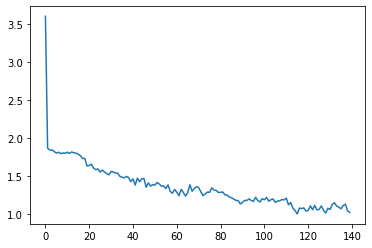

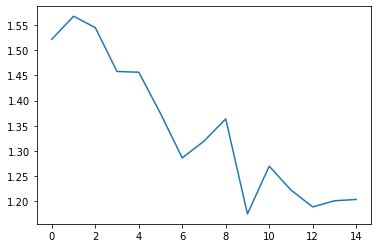

In [20]:
train_loss, val_loss = train_model(net, trainloader, valloader)

plt.figure()
plt.plot(train_loss)
plt.show()

plt.figure()
plt.plot(val_loss)
plt.show()

torch.save(net.state_dict(), '/content/subnet2_weights')

In [ ]:
plt.figure()
plt.plot(train_loss)
plt.show()

plt.figure()
plt.plot(val_loss)
plt.show()

NameError: ignored

In [ ]:
torch.save(net.state_dict(), '/content/subnet2_weights')